In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from tqdm import tqdm
import dateparser

import networkx as nx
import matplotlib.pyplot as plt
import imageio
from datetime import datetime
import os
from collections import defaultdict


In [2]:
# read in all graphs
total_graph = nx.read_gexf('graphs/total_graph.gexf')
boulder_graph = nx.read_gexf('graphs/boulder_graph.gexf')
sport_graph = nx.read_gexf('graphs/sport_graph.gexf')
trad_graph = nx.read_gexf('graphs/trad_graph.gexf')

In [15]:
def create_all_subgraphs(graph,from_year=2014,to_year=2025):
    # get the year of the ascent date for all edges in the boulder graph, and build a subgraph for each year. ignore edges that are unknown
    # get the unique years

    allowed_years = [(str(i)) for i in range(from_year,to_year)]
    years = set()

    for u,v,d in graph.edges(data=True):
        if d['Ascent Date'] != 'Unknown':
            year = d['Ascent Date'][:4]
            years.add((year))



    subgraphs = []

    
    for year in tqdm(years):

        if year in allowed_years:
            subgraphs += [(u,v) for u,v,d in graph.edges(data=True) if d['Ascent Date'][:4] == year]


    massive_subgraph = graph.edge_subgraph(subgraphs) 
    return subgraphs, massive_subgraph

In [4]:
def get_top_n_boulders(graph,n):
    grades = defaultdict(list)
    for node,data in graph.nodes(data=True):
        if 'Grade' in data.keys():
            grades[data['Grade']].append(node)
    sorted_grades = sorted(list(set(grades.keys())))

    min_grade = list(sorted_grades[-n:])[0]
    max_grade = list(sorted_grades[-n:])[-1]

    if min_grade == max_grade:
        suffix = f'{min_grade}'
    else:
        suffix = f'{min_grade}_{max_grade}'
    return [grades[grade] for grade in sorted_grades[-n:]],suffix

def plot_graph(subgraphs,year,n=3,climb_category='boulder'):

    # Merge the latest 10 years into one big graph
    
    climb_nodes,f_suffix = get_top_n_boulders(graph=subgraphs[year],n=n)

    # get all nodes from climb_nodes and their neighbors from the graph and create a subgraph
    subgraph = nx.Graph()
    new_nodes = []
    for nodes in tqdm(climb_nodes):
        for node in nodes:
            new_nodes.append(node)
            for neighbor in subgraphs[year].neighbors(node):
                new_nodes.append(neighbor)

    subgraph = nx.subgraph(subgraphs[year],new_nodes)

    # replace the 'Ascent Date' attribute with the month and the year extracted from the string date
    for u,v,d in subgraph.edges(data=True):
        d['Ascent Date'] = d['Ascent Date'][:7]


    plot_graph_gif(subgraph,f'graphs/{climb_category}_{f_suffix}.gif')



def get_sorted_edges_by_ascent_date(graph):
    """Returns edges sorted by 'Ascent Date'."""
    # Return the edges as a list of lists where each list contains all edges with the same 'Ascent Date'
    edges_by_date = {}
    for u, v, d in graph.edges(data=True):
        date = d['Ascent Date']
        if date not in edges_by_date:
            edges_by_date[date] = []
        edges_by_date[date].append((u, v))

    # Sort the edges by 'Ascent Date'
    sorted_edges = sorted(edges_by_date.items(), key=lambda x: datetime.strptime(x[0], '%Y-%m'), reverse=True)


    return sorted_edges

    
def remove_edges_and_plot(graph, sorted_edges, node_positions, filename):
    """Iteratively removes edges by most recent and plots the graph."""
    images = []
    current_graph = graph.copy()


    for i,cur_edges in tqdm(enumerate(sorted_edges)):
        
        
        
        plt.figure(figsize=(10, 10))
        # Use the attribute Name in the plot 
        
        labels = {}
        for node, data in current_graph.nodes(data=True):
            if 'Name' in data:
                labels[node] = data['Name']
            else:
                labels[node] = str(node)

        # Draw the graph with node labels

        betweenness = nx.betweenness_centrality(current_graph)
        node_size = [1000 * betweenness[node] + 100 for node in current_graph.nodes()]

        nx.draw(current_graph, pos=node_positions, labels=labels, with_labels=True, node_size=node_size, font_size=10)
        plt.title(cur_edges[0])
        plt.savefig(f"temp/temp_plot_{i}.png")
        images.insert(0,imageio.imread(f"temp/temp_plot_{i}.png"))
        plt.close()
        # delete the temp plot
        #os.remove(f"temp/temp_plot_{i}.png")

        # remove edges from the current graph
        for e in cur_edges[1]:
            try:
                current_graph.remove_edges_from([e])
            except:
                pass
        
        # Remove isolates (nodes with no connections)
        isolates = list(nx.isolates(current_graph))
        current_graph.remove_nodes_from(isolates)

        # Break if no more nodes left
        if len(current_graph.nodes) == 0:
            break

    # Create GIF from the saved images
    imageio.mimsave(filename, images, duration=5)

def plot_graph_gif(graph, filename="graph_evolution.gif"):

    # If filename or path doesnt exist create it
    if '/' in filename:
        path = '/'.join(filename.split('/')[:-1])
        os.makedirs(path, exist_ok=True)


    print('sorting')
    # remove alle edges where the status doesnt comtain "worked"
    cur_edges = [(u,v,d) for u,v,d in graph.edges(data=True)]

    graph = nx.Graph(graph) 
    for u,v,d in cur_edges:
        if 'worked' not in d['Status'].lower():
            graph.remove_edge(u,v)
    # Get sorted edges by Ascent Date

    # remove isolates   
    isolates = list(nx.isolates(graph))
    graph.remove_nodes_from(isolates)

    sorted_edges = get_sorted_edges_by_ascent_date(graph)



    print('plotting')
    
    # Plot the initial full graph and get node positions
    plt.figure(figsize=(10, 10))
    node_positions = nx.spring_layout(graph)  # Using spring layout for consistent positioning
    nx.draw(graph, pos=node_positions, with_labels=True, node_size=250, font_size=10)
    plt.title("Initial Full Graph")
    plt.show()


    print('removing')
    # Remove edges step by step, create plots and GIF
    remove_edges_and_plot(graph, sorted_edges, node_positions, filename)




100%|██████████| 1/1 [00:00<00:00, 3344.74it/s]


sorting
plotting


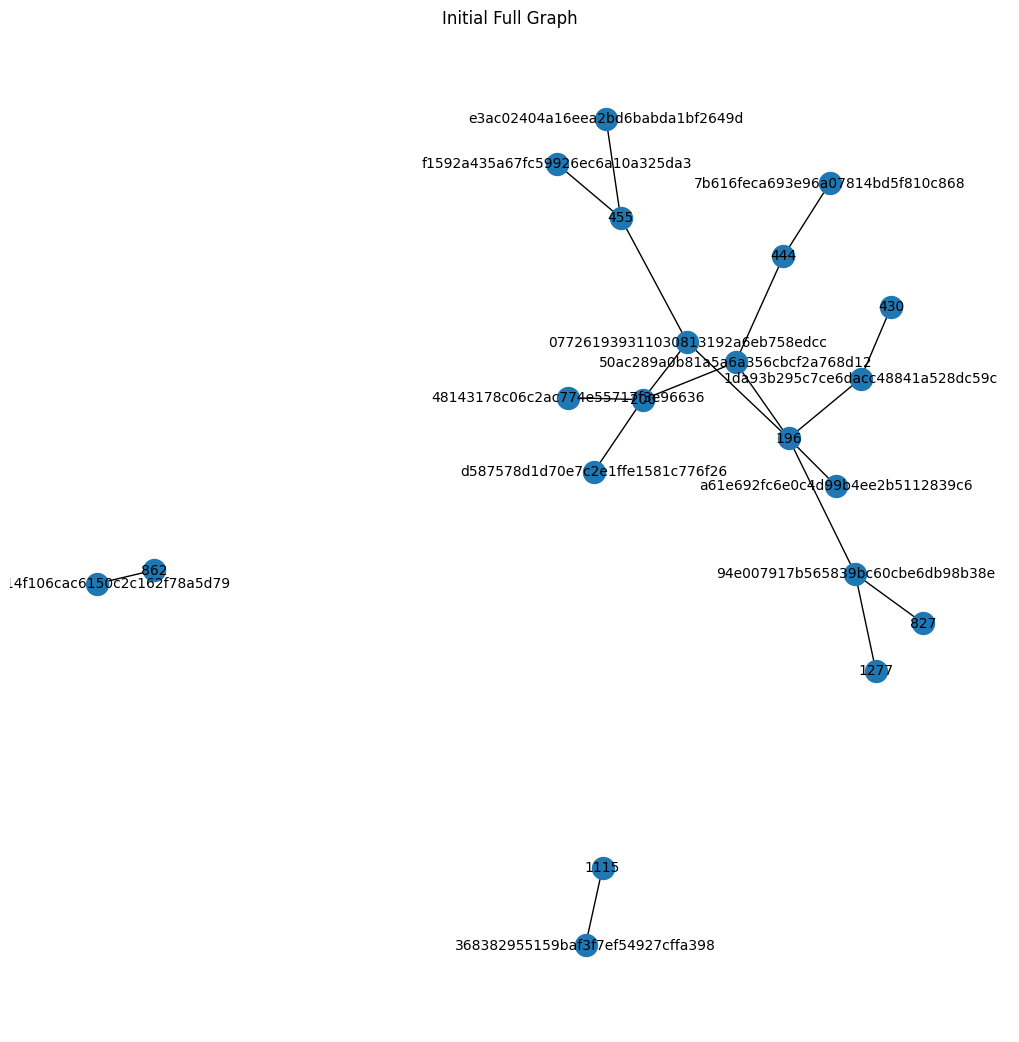

removing


0it [00:00, ?it/s]/var/folders/bf/0wxq49ds7wxdfh6q2mcfm3nm0000gn/T/ipykernel_9970/3271726920.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.insert(0,imageio.imread(f"temp/temp_plot_{i}.png"))
12it [00:03,  3.36it/s]


In [5]:

subgraphs, massive_subgraph = create_all_subgraphs(boulder_graph,from_year=2014,to_year=2025)
plot_graph({"v17":massive_subgraph},year="v17",n=1,climb_category='boulder')

100%|██████████| 2/2 [00:00<00:00, 1858.35it/s]


sorting
plotting


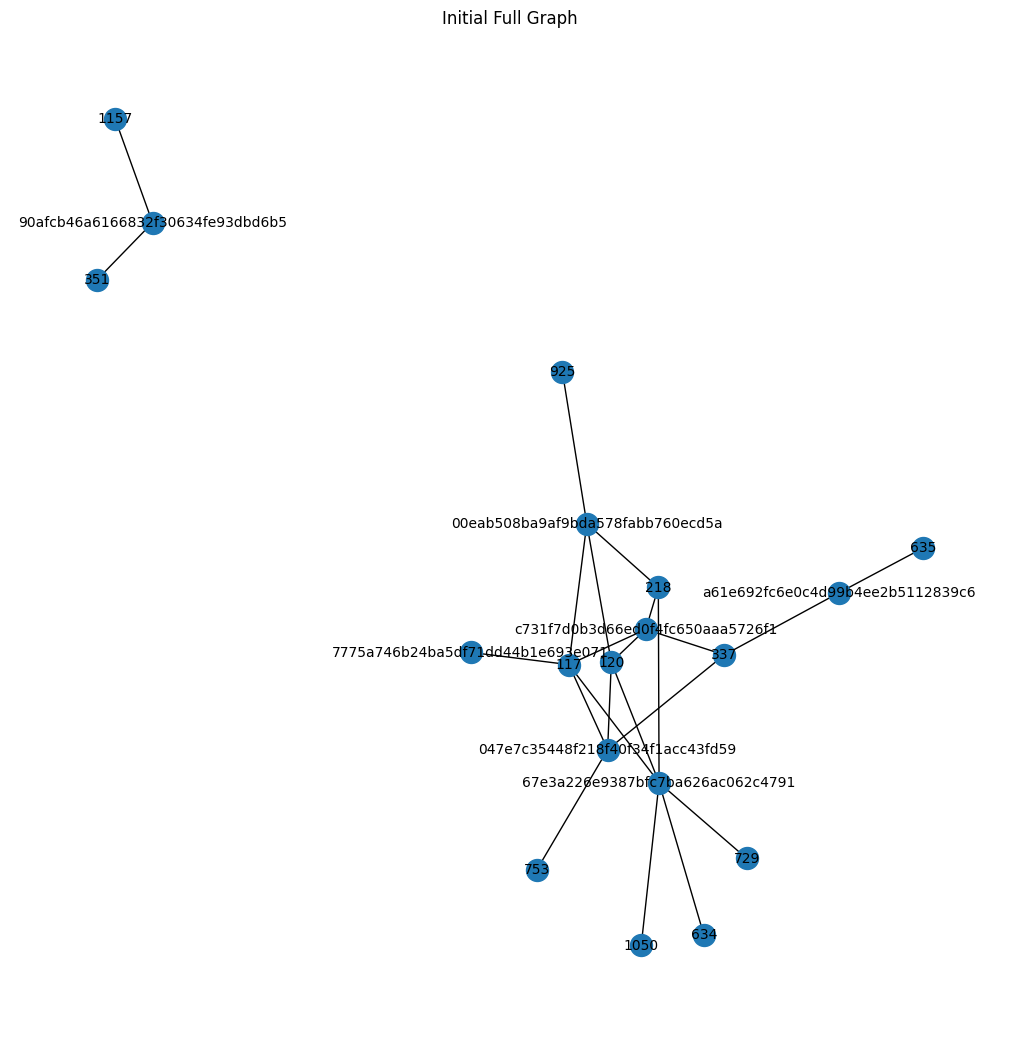

removing


0it [00:00, ?it/s]/var/folders/bf/0wxq49ds7wxdfh6q2mcfm3nm0000gn/T/ipykernel_9970/3271726920.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.insert(0,imageio.imread(f"temp/temp_plot_{i}.png"))
18it [00:05,  3.49it/s]


In [18]:

subgraphs, massive_subgraph = create_all_subgraphs(sport_graph,from_year=2014,to_year=2025)
plot_graph({"v17":massive_subgraph},year="v17",n=2,climb_category='sport')

In [12]:
subgraphs, massive_subgraph = create_all_subgraphs(sport_graph,from_year=2014,to_year=2025)


100%|██████████| 55/55 [00:00<00:00, 1534.17it/s]


In [14]:
massive_subgraph.nodes(data=True)

NodeDataView({'00592636bc03d6457fc4233da6d0ecb2': {'Name': 'Simon Lee', 'label': '00592636bc03d6457fc4233da6d0ecb2'}, '10': {'Name': "Ben's Roof", 'Grade': '7C', 'URL': 'https://climbing-history.org/climb/275/bens-roof', 'label': '10'}, '108': {'Name': 'Levity', 'Grade': '8B+', 'URL': 'https://climbing-history.org/climb/3152/levity', 'label': '108'}, '122': {'Name': 'Brass Knuckles', 'Grade': '8B+', 'URL': 'https://climbing-history.org/climb/3673/brass-knuckles', 'label': '122'}, '00eab508ba9af9bda578fabb760ecd5a': {'Name': 'Jorge Díaz-Rullo', 'label': '00eab508ba9af9bda578fabb760ecd5a'}, '123': {'Name': 'Catalan Witness the Fitness', 'Grade': '8B+', 'URL': 'https://climbing-history.org/climb/556/catalan-witness-the-fitness', 'label': '123'}, '281': {'Name': 'El Elegido', 'Grade': '8B+', 'URL': 'https://climbing-history.org/climb/1768/el-elegido', 'label': '281'}, '604': {'Name': 'Hipoxia', 'Grade': '8C', 'URL': 'https://climbing-history.org/climb/3053/hipoxia', 'label': '604'}, '46': 

100%|██████████| 3/3 [00:00<00:00, 1873.85it/s]


sorting
plotting


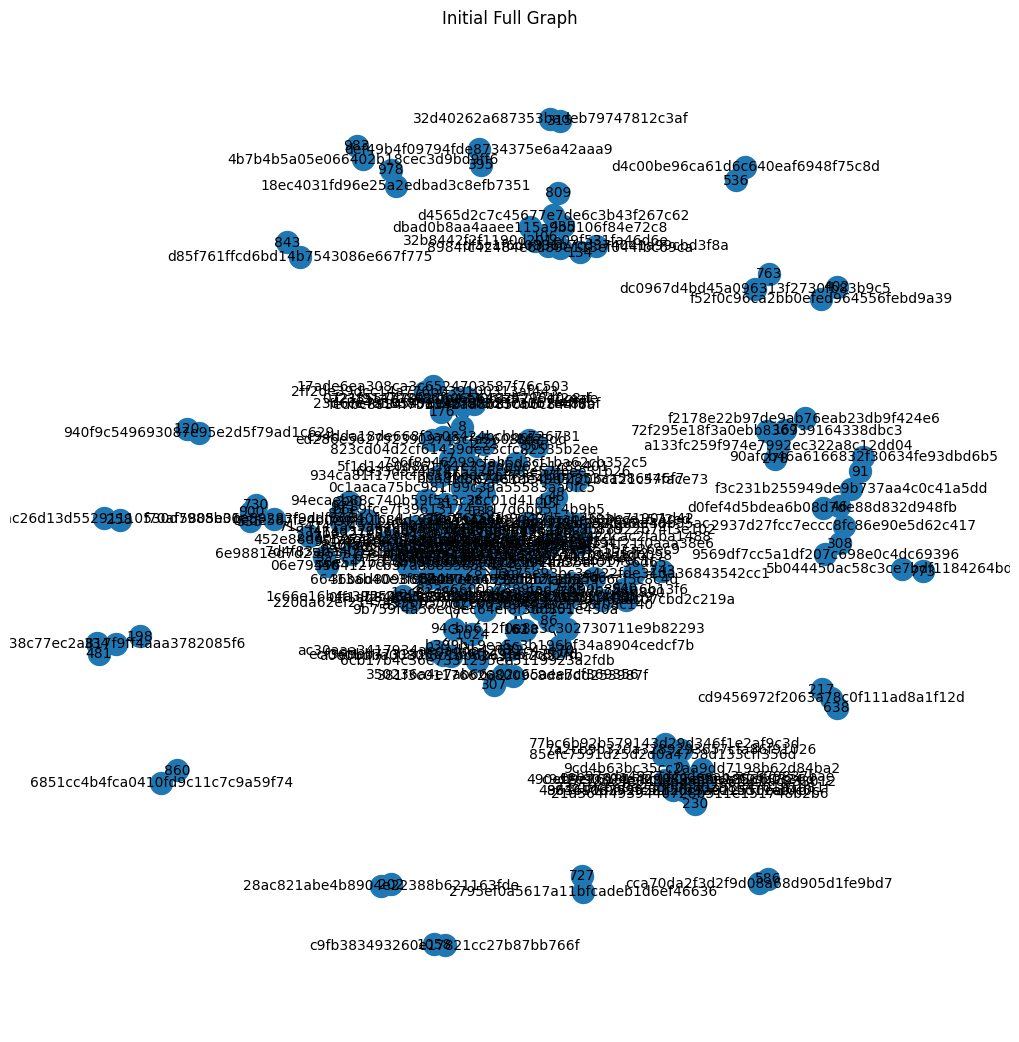

removing


0it [00:00, ?it/s]/var/folders/bf/0wxq49ds7wxdfh6q2mcfm3nm0000gn/T/ipykernel_9970/3271726920.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.insert(0,imageio.imread(f"temp/temp_plot_{i}.png"))
84it [00:42,  1.95it/s]


In [20]:

subgraphs, massive_subgraph = create_all_subgraphs(trad_graph,from_year=2014,to_year=2025)
plot_graph({"v17":massive_subgraph},year="v17",n=3,climb_category='trad')